In [1]:
import tensorflow as tf
import keras
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output as cls
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
train_path = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data/'
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

class_dis = [len(os.listdir(train_path + name)) for name in class_names]

print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 15 
Class Names : ['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']


In [15]:
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [16]:
valid_path = '/kaggle/input/animal-image-classification-dataset/Validation Data/Validation Data/'

class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [18]:
test_path = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data/'

class_dis = [len(os.listdir(test_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [19]:
img_size = (299, 299)
batch_size = 32
# Load Data
train_ds = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode="categorical",
    class_names=class_names,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)
valid_ds = image_dataset_from_directory(
    valid_path,
    labels='inferred',
    label_mode="categorical",
    class_names=class_names,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

def preprocess(images, labels):
    return preprocess_input(images), labels 

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

Found 30000 files belonging to 15 classes.
Found 2000 files belonging to 15 classes.


In [20]:
from glob import glob
test_path = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data/'
# Define the allowed file extensions JPEG, PNG, GIF, BMP
extensions = ["jpeg", "png", "gif", "bmp"]
# Create the glob patterns
files_list = []
for ext in extensions:
    files_list.extend(glob(test_path+f'*/*.{ext}'))

#load the dataset from these files only
list_ds = tf.data.Dataset.list_files(files_list, shuffle=True)
#generate class names
class_names = np.array(sorted([item.name for item in Path(test_path).glob('*')]))
print(class_names)
#convert the file path to a (img, label) pair
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # categorical encode the label
    return tf.one_hot(tf.argmax(one_hot), depth=len(class_names))
     
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [299, 299])
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.map(preprocess)

['Beetle' 'Butterfly' 'Cat' 'Cow' 'Dog' 'Elephant' 'Gorilla' 'Hippo'
 'Lizard' 'Monkey' 'Mouse' 'Panda' 'Spider' 'Tiger' 'Zebra']


In [21]:
def plot_learning_curves(history, lr):
    # Extract loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss'+" Lr = "+lr)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy'+" Lr = "+lr)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[np.argmax(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

In [24]:
model_inceptionV3 = InceptionV3(include_top=True,weights = None, classes=15, classifier_activation='softmax')
epochs = 15
model_inceptionV3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy", #softmax use crossentroby
    metrics=["accuracy"]
)

model_checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/best_at_{epoch}.keras",
    monitor= 'val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq='epoch',
)

history_inceptionV3 = model_inceptionV3.fit(
    train_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    validation_data=valid_ds,
    verbose=1
)


Epoch 1/15
938/938 [==============================] - 254s 254ms/step - loss: 1.9452 - accuracy: 0.3690 - val_loss: 2.1058 - val_accuracy: 0.3775
Epoch 2/15
938/938 [==============================] - 235s 251ms/step - loss: 1.3536 - accuracy: 0.5613 - val_loss: 1.7116 - val_accuracy: 0.4860
Epoch 3/15
938/938 [==============================] - 236s 252ms/step - loss: 1.0307 - accuracy: 0.6685 - val_loss: 1.8889 - val_accuracy: 0.4760
Epoch 4/15
938/938 [==============================] - 237s 252ms/step - loss: 0.8253 - accuracy: 0.7390 - val_loss: 1.3393 - val_accuracy: 0.6045
Epoch 5/15
938/938 [==============================] - 236s 252ms/step - loss: 0.6953 - accuracy: 0.7793 - val_loss: 1.3314 - val_accuracy: 0.6295
Epoch 6/15
938/938 [==============================] - 236s 252ms/step - loss: 0.5833 - accuracy: 0.8151 - val_loss: 2.1836 - val_accuracy: 0.4865
Epoch 7/15
938/938 [==============================] - 236s 251ms/step - loss: 0.5019 - accuracy: 0.8399 - val_loss: 1.2887 -

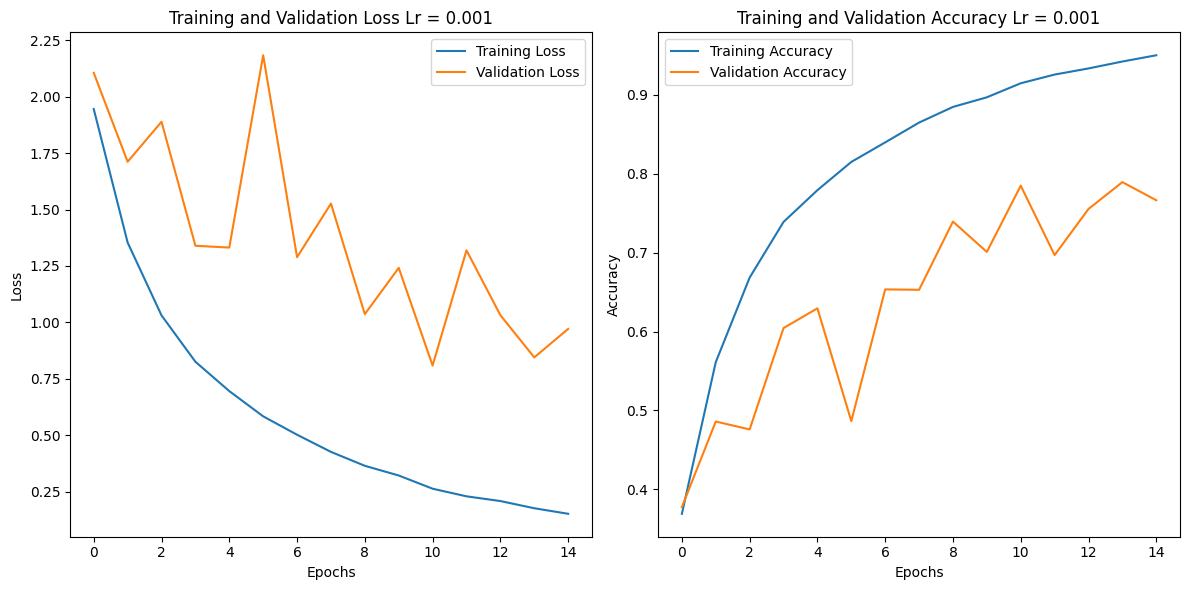

In [25]:
plot_learning_curves(history_inceptionV3, "0.001")

In [29]:
model_inceptionV3 = InceptionV3(include_top=True,weights = None, classes=15, classifier_activation='softmax')
model_inceptionV3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model_inceptionV3.load_weights("/kaggle/working/best_at_14.keras")

In [30]:
loss_val, accuracy = model_inceptionV3.evaluate(test_ds)
print("Loss value = ", loss_val)
print("accuracy = ", accuracy)

71/71 [==============================] - 8s 72ms/step - loss: 0.9599 - accuracy: 0.7769
Loss value =  0.9599142074584961
accuracy =  0.7768959403038025


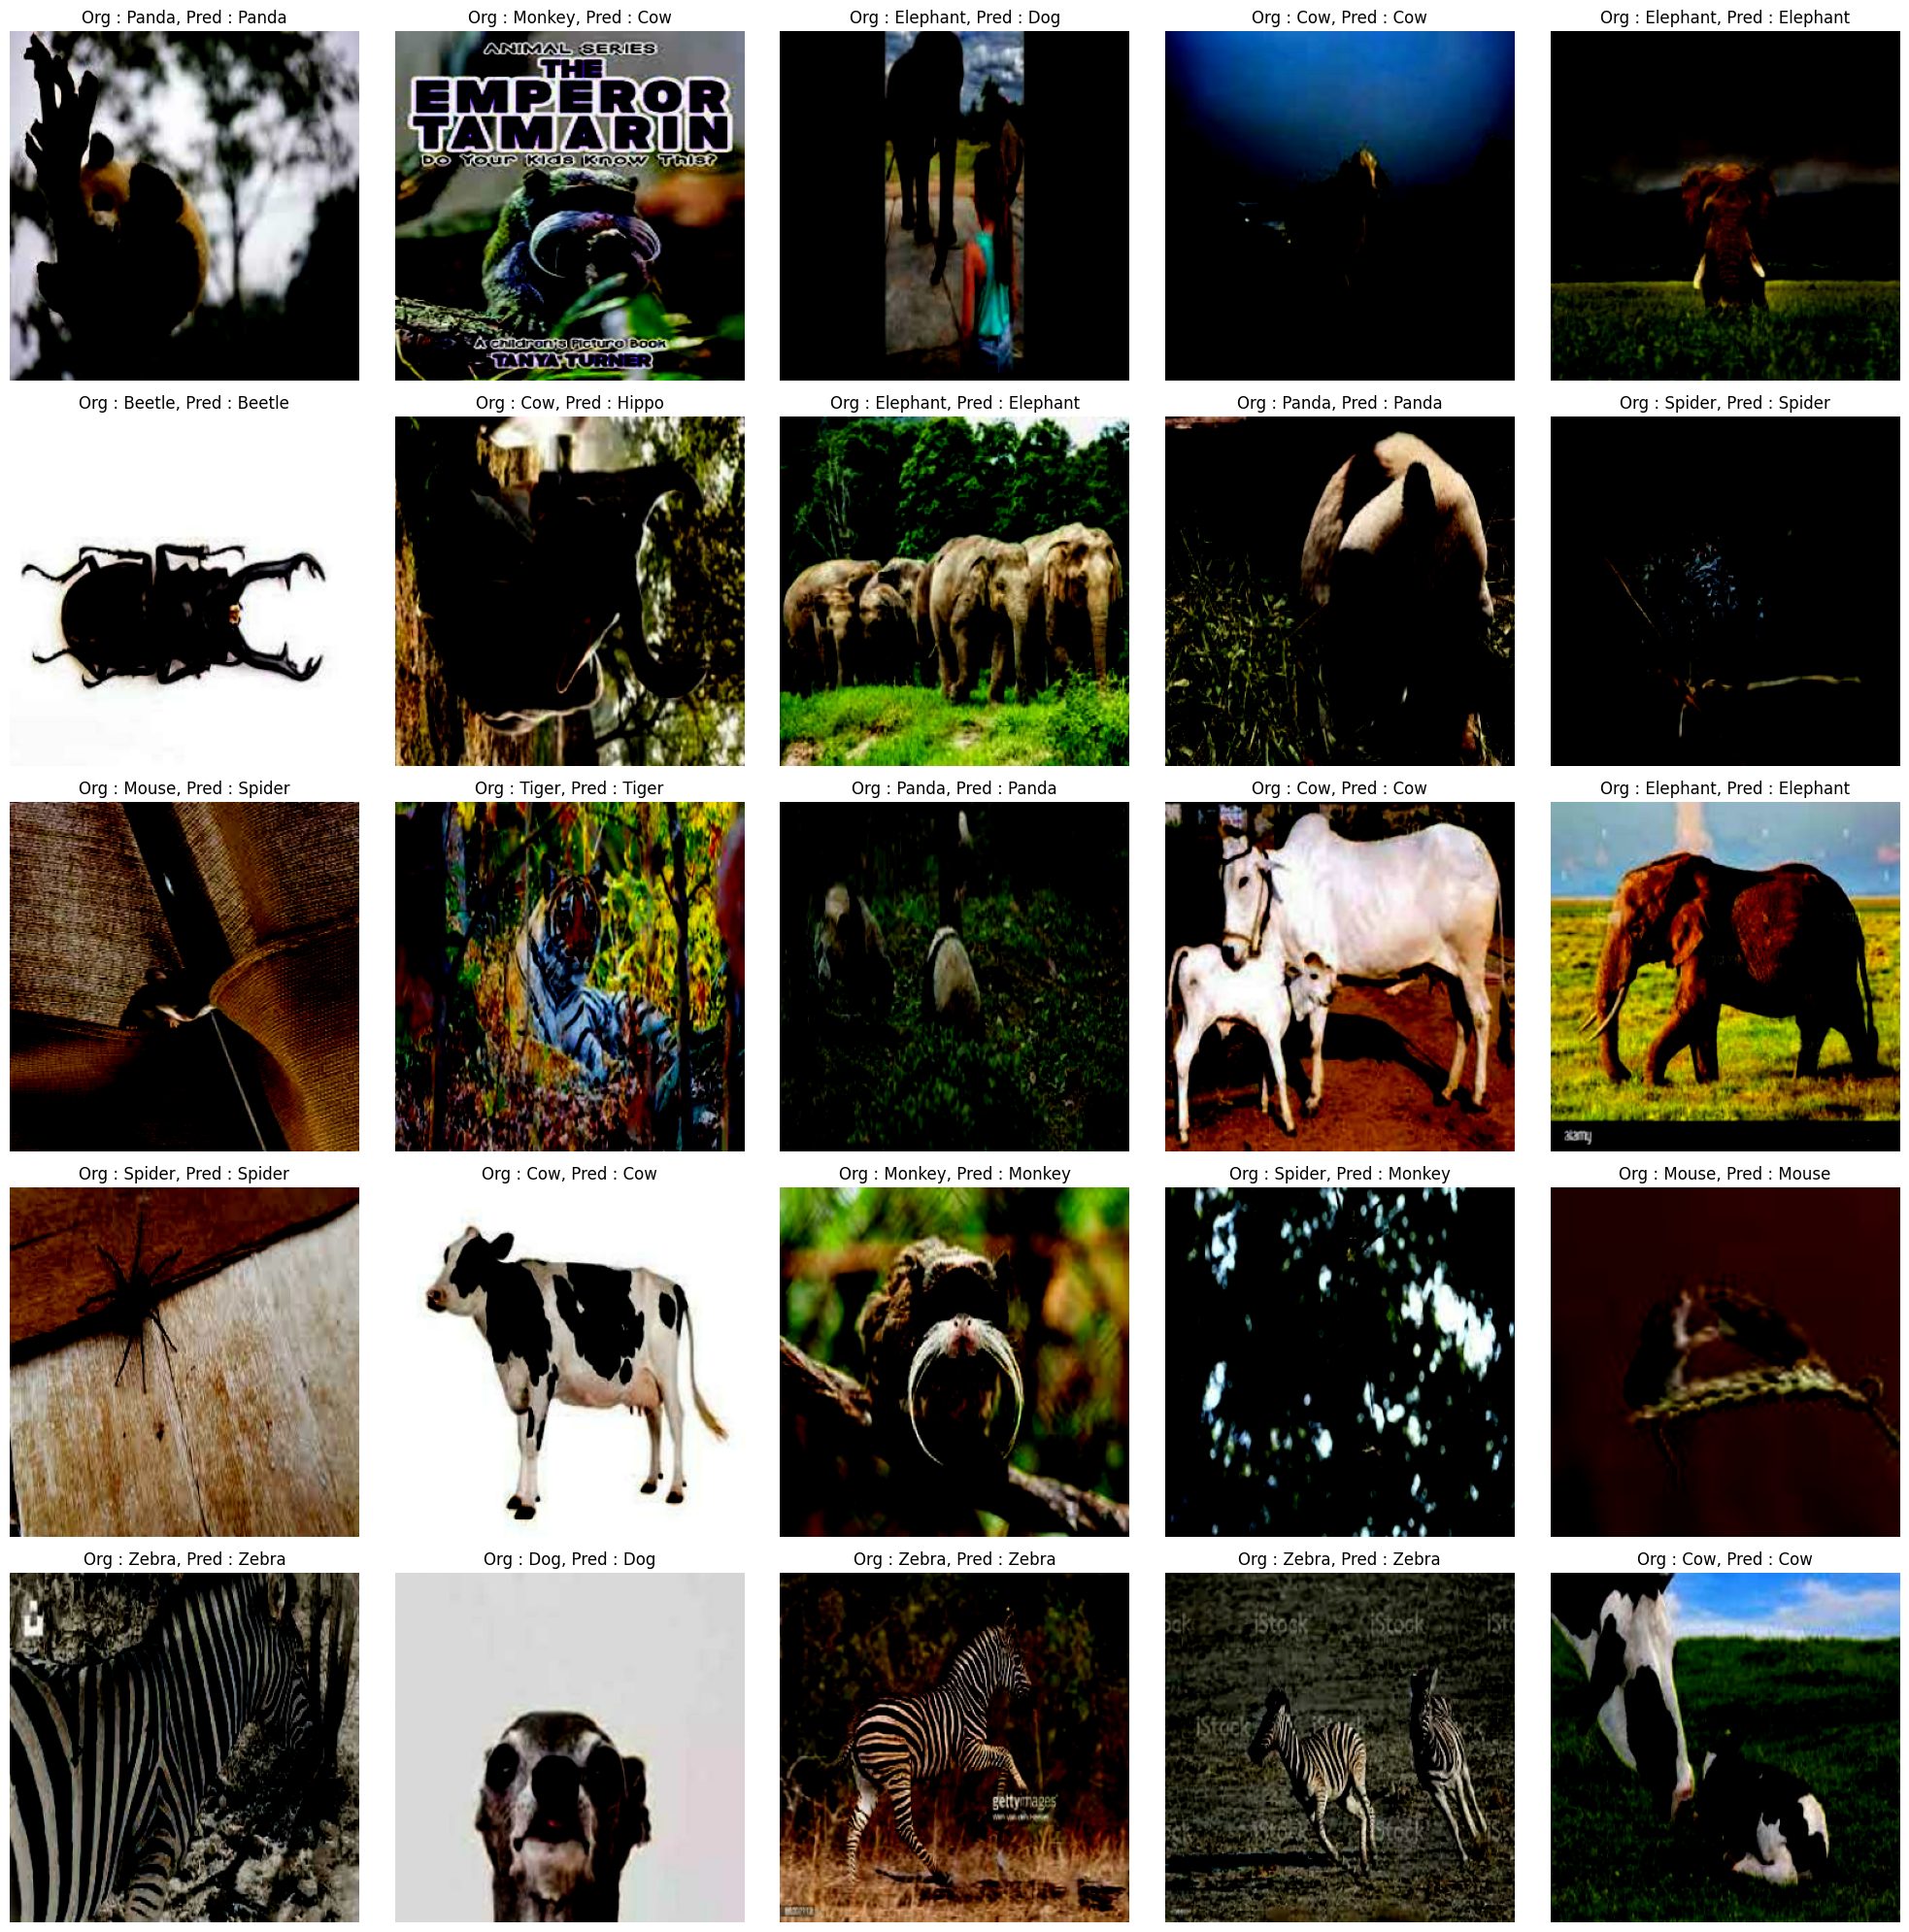

In [31]:
show_images(model=model_inceptionV3, data=test_ds)

In [33]:
model_inceptionV3.save("InceptionNet.h5")
model_inceptionV3.save("InceptionNet.keras")